In [8]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import IPython
import IPython.display

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas import concat
from pandas import DataFrame

import datetime,os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import math
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error   #,r2_score,mean_absolute_error,mean_absolute_percentage_error

In [3]:
# File name and Path
cwd = os.getcwd()
path_adress = "/Import_Dataset/"

# ข้อมูล พิกัดสถานที่เเละรายชื้ออ้างอิงสถานที่ตรวจวัด
file_name_st = 'Data_lat_long_Rice research Center'
csv_file_st = cwd + path_adress + file_name_st + '.csv'

df_st = pd.read_csv(csv_file_st)
print("All low RiceCenter {} station" .format(df_st.shape[0]))

data_list_st_num = list(range(0, len(df_st)))
data_list_st_name = []
data_list_st_name = df_st['nameEng'].values.tolist()
data_list_st_lat = df_st['Latitude'].values.tolist()
data_list_st_long = df_st['Longitude'].values.tolist()

#################-- Moving Averag data --#################
def mavr_dataset(frames_sma,rolling_num,our_rate,mode):    
    h_name = list(frames_sma)
    if mode == 'sum':
        frames_sma['mirid bug'] = frames_sma['mirid bug'].rolling(rolling_num, min_periods=1).sum().round(1)
        frames_sma['bph'] = frames_sma['bph'].rolling(rolling_num, min_periods=1).sum().round(1)
        frames_sma['precip'] = frames_sma['precip'].rolling(rolling_num, min_periods=1).sum().round(1)
    else:
        frames_sma['mirid bug'] = frames_sma['mirid bug'].rolling(rolling_num, min_periods=1).mean().round(1)
        frames_sma['bph'] = frames_sma['bph'].rolling(rolling_num, min_periods=1).mean().round(1)
        frames_sma['precip'] = frames_sma['precip'].rolling(rolling_num, min_periods=1).mean().round(1)
   
    for i in range(7,12):
        frames_sma[h_name[i]] = frames_sma[h_name[i]].rolling(rolling_num, min_periods=1).mean().round(1)

    constant_subset = frames_sma[::our_rate] 
    return constant_subset

#################-- creat_dataset  --#################
def creat_dataset(st_BPH = 'ALL', y_1='2015', y_2='2019', m_avr='ALL'):
    for i in range(len(data_list_st_num)):
        st = i
        file_name = df_st['nameEng'][data_list_st_num[st]]
        name_input = file_name
        name_locals = 'stN_' + file_name

        # File name and Path
        csv_file = cwd + path_adress + name_input + '.csv'
        # index_col=0 , index_col=None
        dataset = pd.read_csv(csv_file, header=0,
                              index_col=0, encoding="TIS-620")

        if m_avr == '3-DAY-All-':
            locals()[name_locals] = mavr_dataset(dataset,3,1,'mean')
        elif m_avr == '7-DAY-All':
            locals()[name_locals] = mavr_dataset(dataset,7,1,'mean')
        elif m_avr == '14-DAY-All':
            locals()[name_locals] = mavr_dataset(dataset,14,1,'mean')
        elif m_avr == '3-DAY-Sampling':
            locals()[name_locals] = mavr_dataset(dataset,3,3,'sum')
        elif m_avr == '7-DAY-Sampling':
            locals()[name_locals] = mavr_dataset(dataset,7,7,'sum')
        elif m_avr == '14-DAY-Sampling':
            locals()[name_locals] = mavr_dataset(dataset,14,14,'sum')
        else :
            locals()[name_locals] = dataset
            # print(f'Dataframe name_station: {st+1 , name_input}')
        print('wait......')
        del dataset
        clear_output(wait=True)

    date_start = y_1 + '-01' + '-01'
    date_stop = y_2 + '-12' + '-31'

#---------------------------------------------------------------------------------------------------------------------------------------------------#
    if st_BPH != 'ALL' :
        # file_name = df_st['nameEng'][data_list_st_num[st_BPH]]
        file_name = st_BPH
        locals_input = 'stN_' + file_name
        print(locals_input)
        dataset_st = locals()[locals_input].loc[date_start:date_stop]
        frames_st = dataset_st
    else:
        m = 0
        for j in range(len(data_list_st_num)):
            # for j in range(df_st.shape[0]):
            # file_name = df_st['nameEng'][j]
            file_name = df_st['nameEng'][data_list_st_num[j]]
            locals_input = 'stN_' + file_name
            print(locals_input)
            dataset_st = locals()[locals_input].loc[date_start:date_stop]
            clear_output(wait=True)
            if m == 0:
                frames_st = dataset_st
                m = m+1
                print(m)
            else:
                frames_st = [frames_st, dataset_st]
                frames_st = pd.concat(frames_st)

    # dataset    
    frames = frames_st
    return frames
#---------------------------------------------------------------------------------------------------------------------------------------------------#

#################-- Drop Colum  --#################
def drop_col(df_drop,drop = ['address']):
    for j in range(len(drop)):
        df_drop = df_drop.drop(drop[j], axis=1)
    return df_drop

#################--      Plot        --#################
def plot_data(frames_train,plot_cols,df_name,start='2015',end='2017',st = 'ALL'):
    #ตรวจสอบข้อมูล dataset 
    if st == 'ALL':
        df_plot = frames_train[plot_cols]
    else:
        df_plot = frames_train[plot_cols].loc[start:end]
    
    plt.figure()    
    # df_plot.plot(lw=1,grid=True,figsize=(13,30),subplots=True)
    # df_plot.plot(lw=1,grid=True,subplots=True)
    # df_plot.plot(marker='.',grid=True,linestyle = 'solid',subplots=True)
    df_plot.plot(marker='.',grid=True,linestyle = 'solid')
    plt.xlabel('Date time-'+ df_name)
    plt.legend()
    # plt.show()   

#################--   get list of folders in directory   --#################
dir_path = cwd + "/Export_lstm/model/"
def get_list_folder():
    folder_list = os.listdir(dir_path)
    return folder_list

def get_file_model(file_name):
    txt = dir_path+file_name+"/Training_model_data_discription.txt"
    string_data = open(txt,"r").read()
    list_txt = list(string_data.split("\n"))
    return list_txt
    

All low RiceCenter 34 station


In [4]:
#########################################-- Dashboard Input Data--#########################################
ALL = 'ALL'

def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

#################-- DataFrame station --#################
output_df_st = widgets.Output()
def dropdown_station_eventhandler(change):
    output_df_st.clear_output()
    with output_df_st:  
        if (change.new == ALL):
            display(df_st)
        else:
            display(df_st[df_st.nameEng == change.new])

#################-- DataFrame station --#################
output_df_st_predict = widgets.Output()
def dropdown_station_predict_eventhandler(change):
    output_df_st_predict.clear_output()
    with output_df_st_predict:  
        if (change.new == ALL):
            display(df_st)
        else:
            display(df_st[df_st.nameEng == change.new])

#################-- load data  --#################


output_df_train = widgets.Output()
output_df_val = widgets.Output()
output_df_test = widgets.Output()
output_df_col = widgets.Output()
def clicked_load(b):
    global df_out_train
    global df_out_val
    global df_out_test
    global selected_data 
    output_df_train.clear_output()
    output_df_val.clear_output()
    output_df_test.clear_output()
    output_df_col.clear_output()
    with output_df_train:
        df_out_train = creat_dataset(dropdown_name_st.value,dropdown_year_train1.value,dropdown_year_train2.value,dropdown_sampling_data.value)
        display(df_out_train)
        # display(creat_dataset(dropdown_name_st.value,dropdown_year_train1.value,dropdown_year_train2.value,dropdown_sampling_data.value))
    with output_df_val:
        df_out_val = creat_dataset(dropdown_name_st.value,dropdown_year_val1.value,dropdown_year_val2.value,dropdown_sampling_data.value)
        display(df_out_val)
        # display(creat_dataset(dropdown_name_st.value,dropdown_year_val1.value,dropdown_year_val2.value,dropdown_sampling_data.value))
    with output_df_test:
        df_out_test = creat_dataset(dropdown_name_st.value,dropdown_year_test1.value,dropdown_year_test2.value,dropdown_sampling_data.value)
        display(df_out_test)
        # display(creat_dataset(dropdown_name_st.value,dropdown_year_test1.value,dropdown_year_test2.value,dropdown_sampling_data.value))
    with output_df_col:
        checkbox_objects = []
        # global selected_data
        data = sorted(set(chek_list(df_out_train)),reverse=True)     
        names = []
        for key in data:
                checkbox_objects.append(widgets.Checkbox(value=True, description=key))
                names.append(key)
 
        arg_dict = {names[i]: checkbox for i, checkbox in enumerate(checkbox_objects)}
        ui = widgets.HBox(children=checkbox_objects)
        display(ui)
             
        selected_data = []
        def select_data(**kwargs):
            selected_data.clear()
            for key in kwargs:
                if kwargs[key] is True:
                    selected_data.append(key)
            print(selected_data)

        widgets.interactive_output(select_data, arg_dict)
    
 
#################-- Export data  --#################
df_train = widgets.Output()
df_val = widgets.Output()
df_test = widgets.Output()
def clicked_export(b):
    df_train.clear_output()
    df_val.clear_output()
    df_test.clear_output()
    global frames_train
    global frames_val
    global frames_test
    with df_train:
        frames_train = drop_col(df_out_train,selected_data) 
        display(frames_train)
    with df_val:
        frames_val = drop_col(df_out_val,selected_data) 
        display(frames_val)  
    with df_test:
        frames_test = drop_col(df_out_test,selected_data) 
        display(frames_test)  

def chek_list(df_ch):
        data_col = set(df_ch.columns)
        return data_col      

#################----------------------------- DashBoard display ----------------------------------#################
dropdown_name_st = widgets.Dropdown(options = unique_sorted_values_plus_ALL(df_st.nameEng),description='station :')
dropdown_sampling_data = widgets.Dropdown(options = ['All','3-DAY-All','7-DAY-All','14-DAY-All','3-DAY-Sampling','7-DAY-Sampling','14-DAY-Sampling'],valure = 'All-DAY',description='Sampling :')
dropdown_year_train1 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],description='Year-train :')
dropdown_year_train2 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],value = '2017')
dropdown_year_val1 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],value = '2018',description='Year-val :')
dropdown_year_val2 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],value = '2018')
dropdown_year_test1 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],value = '2019',description='Year-test :')
dropdown_year_test2 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],value = '2019')


button_download = widgets.Button(description='load data',disabled=False,button_style='success',tooltip='Click me',icon='check')
button_export = widgets.Button(description='export dataset',disabled=False,button_style='success',tooltip='Click me',icon='check')

button_download.on_click(clicked_load)
button_export.on_click(clicked_export)

dropdown_name_st.observe(dropdown_station_eventhandler, names='value')


item_layout = widgets.Layout(margin='0 0 15px 0')
input_widgets_row1 = widgets.HBox([dropdown_name_st,dropdown_year_train1,dropdown_year_train2,dropdown_year_val1,dropdown_year_val2,dropdown_year_test1,dropdown_year_test2],layout = item_layout)
input_widgets_row2 = widgets.HBox([dropdown_sampling_data,button_download,button_export],layout = item_layout)

tab_dataset = widgets.Tab([output_df_st,output_df_train,output_df_val,output_df_test,output_df_col,df_train,df_val,df_test])
tab_dataset.set_title(0, 'Dataset station')
tab_dataset.set_title(1, 'train-data')
tab_dataset.set_title(2, 'validation-data')
tab_dataset.set_title(3, 'test-data')
tab_dataset.set_title(4, 'Drop-data')
tab_dataset.set_title(5, 'Dataset-train')
tab_dataset.set_title(6, 'Dataset-validation')
tab_dataset.set_title(7, 'Dataset-test')
dashboard_dataset = widgets.VBox([input_widgets_row1,input_widgets_row2])
display(dashboard_dataset)
display(tab_dataset)


In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
def plot_data(frames_train,df_name):
    #ตรวจสอบข้อมูล dataset 
    plt.figure()
    df_plot = frames_train
    df_plot.plot(lw=1,grid=True,figsize=(15,7),subplots=True)
    plt.xlabel('time-(day)'+ df_name)
    plt.legend()
    # plt.show()

In [10]:
def train_loop(Epoc,n_input,n_output,Export_folder_name):

    #Multivariate = [temp,precip,humidity,bph] 4
    #Multivariate = [temp,precip,humidity,day,month,bph] 6
    #Multivariate = [temp,precip,humidity,day,month,bph] + [rice] 

    values_train = frames_train.values    
    n_features = frames_train.shape[1]

    values_validation = frames_val.values
    plot_data(frames_train,'  Dataset')

    # In_day   Out_day
    #    7      1
    #    7      3
    #    7      5
    #    7      7
    #   14      1
    #   14      3
    #   14      5
    #   14      7
    #   21      1
    #   21      3
    #   21      5
    #   21      7
    # Export_folder_name = "/Users/MSI-1016TH/Documents/ผลการทดลอง/"
    # Export_folder_name = "/home/np13-sut-pc/Documents/ผลการทดลอง/"
    Epochs = int(Epoc)
    n_day = int(n_input)
    n_out = int(n_output)

    #train data
    # ensure all data is float
    values = values_train.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, n_day, n_out)
    # print(reframed.shape)
    # print(reframed.head())

    # predict datasets
    values = reframed.values
    train = values

    #input 
    n_obs = n_day * n_features
    # train_X, train_y = train[:, :n_obs], train[:, -n_features]
    train_X, train_y = train[:, :n_obs], train[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)  #for train


    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_day, n_features))
    print(train_X.shape, train_y.shape)

    #validation data
    # ensure all data is float
    values = values_validation.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, n_day, n_out)

    # predict datasets
    values = reframed.values
    test = values

    #output 
    n_obs = n_day * n_features
    # test_X, test_y = test[:, :n_obs], test[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -1]
    print(test_X.shape, len(test_X), test_y.shape)  #for train

    # reshape input to be 3D [samples, timesteps, features]
    test_X = test_X.reshape((test_X.shape[0], n_day, n_features))
    print(test_X.shape, test_y.shape)


    ##------train-----## 
    # Model A LSTM 
    model = tf.keras.models.Sequential([
                    # Shape [batch, time, features] => [batch, time, lstm_units]
                    keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]),activation='relu'),  #relu tanh
                    keras.layers.Dense(units=1)
        ])
    # Model B Bidirectional-LSTM
    # model = tf.keras.models.Sequential([
    #                   # Shape [batch, time, features] => [batch, time, lstm_units]
    #                   keras.layers.Bidirectional(layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]),activation='relu')),  #relu tanh
    #                   keras.layers.Dense(units=1)
    #     ])
    # Model C Stacked_LSTM
    # model = tf.keras.models.Sequential([
    #                   # Shape [batch, time, features] => [batch, time, lstm_units]
    #                   keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True,activation='relu'),
    #                   keras.layers.LSTM(50, activation='relu'),
    #                   keras.layers.Dense(units=1)
    #             ])
                
    Optimizer = tf.keras.optimizers.Adam(0.0001)
    model.compile(Optimizer, loss='mae', metrics=['accuracy'])
    # model.summary()

    # fit network
    batch_size = 128
    history = model.fit(train_X, train_y, 
                        epochs=Epochs, 
                        batch_size=batch_size, 
                        validation_data=(test_X, test_y), 
                        verbose=2, 
                        # callbacks=[cp_callback,es_callback], 
                        shuffle=False)

    # plot history
    from matplotlib import pyplot as plt1
    def plot_loss(history):
        plt1.figure(figsize=(10,7))
        plt1.plot(history.history['loss'], label='train')
        # plt.plot(history.history['val_loss'], label='val')
        plt1.xlabel('Epoch')
        plt1.ylabel('Error')
        plt1.legend()
        plt1.grid(True)
    #     plt.show()

    plot_loss(history)

    plot_name_T = 'output model A '+str(n_day)+'-'+str(n_out)+'-'+str(Epochs)+'-'+str(len(list(frames_train.columns)))+'V'+'-T'+'.png'
    plt1.savefig(Export_folder_name + plot_name_T)
    plt1.close()

    #####################################################################################################

    values_predict = frames_test.values
    n_features = frames_test.shape[1]
    df = frames_test.reset_index()
    date_time_predict = pd.to_datetime(df.pop('date'))

    # ensure all data is float
    values = values_predict.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
        
    # frame as supervised learning
    reframed = series_to_supervised(scaled, n_day, n_out)
    # print(reframed.shape)
    # print(reframed.head())
        
    # predict datasets
    values = reframed.values
    # n_train_day = int(values.shape[0]*0.9)
    # train = values[:n_train_day, :]
    test = values
        
    # predict into input and outputs
    n_obs = n_day * n_features
    # test_X, test_y = test[:, :n_obs], test[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -1]
    print(test_X.shape, len(test_X), test_y.shape)
        
    # reshape input to be 3D [samples, timesteps, features]
    test_X = test_X.reshape((test_X.shape[0], n_day, n_features))
    print(test_X.shape, test_y.shape)
        
    # # make a prediction
    yhat = model.predict(test_X,verbose=0)
    test_X_reshape = test_X.reshape((test_X.shape[0], n_day*n_features)) 

    from cProfile import label
    from numpy import concatenate

    # invert scaling for forecast
    # inv_yhat = concatenate((yhat, test_X[:, -29:]), axis=1)
    inv_yhat = concatenate((test_X_reshape[:, :(n_features-1)], yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y_reshape = test_y.reshape((len(test_y), 1))
    # inv_y = concatenate((test_y, test_X[:, -29:]), axis=1)
    inv_y = concatenate((test_X_reshape[:, :(n_features-1)], test_y_reshape), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]


    ##### plot and save ###

    df_out = pd.DataFrame(list(date_time_predict[n_day+n_out-1:]),columns=['date'])
    df_out['actual'] = pd.DataFrame(list(inv_y))
    df_out['predict'] = pd.DataFrame(list(inv_yhat))

    # calculate RMSE
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state([df_out['actual']], [df_out['predict']])
    rmse_all = m.result().numpy()
    print('RMSE-all: %.3f' % rmse_all)


    d_range = 365-n_day-n_out-1
    pre_start = 0 

    pre_stop = pre_start+d_range

    # calculate RMSE
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(df_out['actual'][pre_start:pre_stop], df_out['predict'][pre_start:pre_stop])
    rmse = m.result().numpy()
    print('RMSE f1: %.3f' % rmse)

    # calculate RMSE
    rmse2 = mean_squared_error(df_out['actual'][pre_start:pre_stop], df_out['predict'][pre_start:pre_stop], squared=False)
    print('RMSE f2: %.4f' % rmse2)

    strings = list(frames_test.columns)
    textstr = '\n'.join(strings[:12])

    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(10)

    ax.plot(df_out['date'][pre_start:pre_stop],df_out['actual'][pre_start:pre_stop],label='actual')
    ax.plot(df_out['date'][pre_start:pre_stop],df_out['predict'][pre_start:pre_stop],label='predict')

    ax.legend(loc='upper right')
    ax.set_title('Multivariate-LSTM model-A' +'  RMSE: %.2f' % rmse)
    ax.set_xlabel('time (day) '+'(%d-'%n_day+'%d-'%n_out+'Epoch %d)'%Epochs)
    ax.set_ylabel('BPH Volume')
    ax.grid(True)

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    file_name = 'output model A '+str(n_day)+'-'+str(n_out)+'-'+str(Epochs)+'-'+str(len(strings))+'V'
    # plot_name = 'output model A '+str(n_day)+'-'+str(n_out)+'-'+str(Epochs)+'-'+str(len(strings))+'V'+'.png'
    plot_name = file_name +'.png'
    plt.savefig(Export_folder_name + plot_name)
    plt.show()
    plt.close()

    #Output : file name and Path Save file
    # file_name_save = 'output model A '+str(n_day)+'-'+str(n_out)+'-'+str(Epochs)+'-'+str(len(strings))+'V'+'.csv'
    file_name_save = file_name +'.csv'
    dataset_path_save = Export_folder_name + file_name_save
    df_out.to_csv(dataset_path_save, index=False, encoding="TIS-620")
    print("{} {}" .format(dataset_path_save,len(df_out)))
    del df_out,model
    return  str(file_name),str(rmse),str(rmse_all)

(37239, 126) 37239 (37239,)
(37239, 21, 6) (37239,)
(12385, 126) 12385 (12385,)
(12385, 21, 6) (12385,)
Epoch 1/100
291/291 - 13s - loss: 0.0073 - accuracy: 0.4066 - val_loss: 0.0108 - val_accuracy: 0.4866 - 13s/epoch - 44ms/step
Epoch 2/100
291/291 - 11s - loss: 0.0058 - accuracy: 0.4066 - val_loss: 0.0102 - val_accuracy: 0.4866 - 11s/epoch - 37ms/step
Epoch 3/100
291/291 - 10s - loss: 0.0055 - accuracy: 0.4066 - val_loss: 0.0104 - val_accuracy: 0.4866 - 10s/epoch - 35ms/step
Epoch 4/100
291/291 - 10s - loss: 0.0050 - accuracy: 0.4066 - val_loss: 0.0097 - val_accuracy: 0.4866 - 10s/epoch - 35ms/step
Epoch 5/100
291/291 - 11s - loss: 0.0048 - accuracy: 0.4066 - val_loss: 0.0089 - val_accuracy: 0.4866 - 11s/epoch - 36ms/step
Epoch 6/100
291/291 - 11s - loss: 0.0047 - accuracy: 0.4066 - val_loss: 0.0093 - val_accuracy: 0.4866 - 11s/epoch - 36ms/step
Epoch 7/100
291/291 - 10s - loss: 0.0046 - accuracy: 0.4066 - val_loss: 0.0085 - val_accuracy: 0.4866 - 10s/epoch - 35ms/step
Epoch 8/100
29

<Figure size 432x288 with 0 Axes>

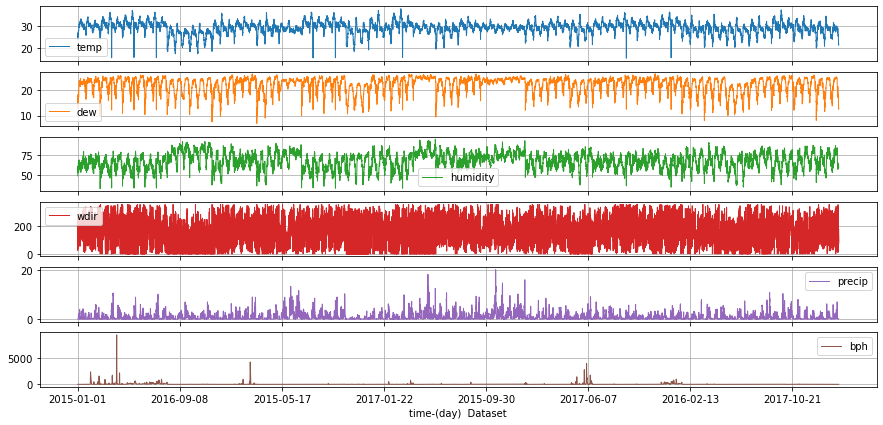

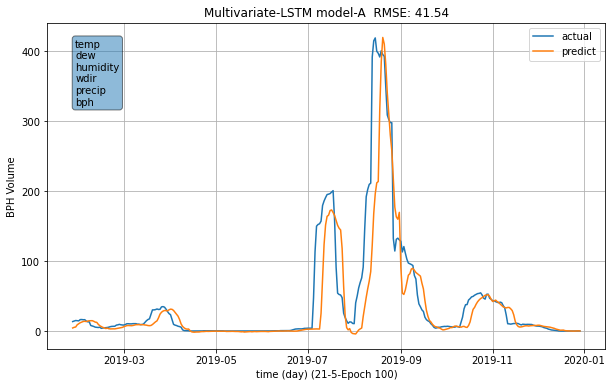

/Users/MSI-1016TH/Documents/ผลการทดลอง/output model A 21-5-100-6V.csv 12385
output model A 21-5-100-6V
41.536255
/Users/MSI-1016TH/Documents/ผลการทดลอง/output model LSTM rmse run 1.csv 1


In [12]:
Export_folder_name = "/Users/MSI-1016TH/Documents/ผลการทดลอง/"
# Export_folder_name = "/home/np13-sut-pc/Documents/ผลการทดลอง/"
Epochs = [100]
n_in = [7,14,21]
n_out = [1,3,5,7]

# n_in = [21]
# n_out = [5]
list_name_result = []
list_rmse_result = []
list_rmse_all_result = []
for i in range(len(Epochs)):
    for j in range(len(n_in)):
         for k in range(len(n_out)):
            result_train = train_loop(Epochs[i],n_in[j],n_out[k],Export_folder_name)
            print(result_train[0])
            print(result_train[1])
            list_name_result.append(result_train[0]) 
            list_rmse_result.append(result_train[1])
            list_rmse_all_result.append(result_train[2]) 

d = {'name': list_name_result, 'rmse': list_rmse_result,'rmse_all': list_rmse_all_result}
df_result = pd.DataFrame(data=d)


file_name = 'output model LSTM rmse run 1'
file_name_save = file_name +'.csv'
dataset_path_save = Export_folder_name + file_name_save
df_result.to_csv(dataset_path_save, index=False, encoding="TIS-620")
print("{} {}" .format(dataset_path_save,len(df_result)))
